Load toolboxes:

In [2]:
import helper
import plot_settings

# import packages
import pymaid
import navis
import pickle
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr, ttest_ind

path_plots = 'plots/'

# Set matplotlib style
plt.rcParams.update(plot_settings.params)

### Load the required data from the server:

In [3]:
# load the remote instance of pymaid to the server
l1em = pymaid.connect_catmaid(server="https://l1em.catmaid.virtualflybrain.org/", api_token=None, max_threads=50, caching=False)    # L1 Larval CNS
l3vnc = pymaid.connect_catmaid(server="https://l3vnc.catmaid.virtualflybrain.org/", api_token=None, max_threads=50, caching=False, project_id=2)  # L3 Larval VNC

neurons_str = 'Gerhard et al. 2017'

# load neurons
# l1_neurons = pymaid.get_neurons('annotations:' + neurons_str, remote_instance=l1em)
l1_neurons = helper.try_with_retries(pymaid.get_neurons, 5, 'annotations:' + neurons_str, remote_instance=l1em)
l1_neurons.set_neuron_attributes(neurons_str, 'annotation')
# l3_neurons = pymaid.get_neurons('annotations:' + neurons_str, remote_instance=l3vnc)
l3_neurons = helper.try_with_retries(pymaid.get_neurons, 5, 'annotations:' + neurons_str, remote_instance=l3vnc)
l3_neurons.set_neuron_attributes(neurons_str, 'annotation')

# replace ' ' in all the names with '_' to match the names in the database
for neuron in l1_neurons:
    neuron.name = '_'.join(neuron.name.replace(' ', '_').split('_')[:2])
for neuron in l3_neurons:
    neuron.name = '_'.join(neuron.name.replace(' ', '_').split('_')[:2])

# filter out neurons without 'a1' or 'a3' in the name
for neuron in l1_neurons:
    if 'a1' not in neuron.name:
        l1_neurons -= neuron
for neuron in l3_neurons:
    if 'a3' not in neuron.name:
        l3_neurons -= neuron

INFO  : Global CATMAID instance set. Caching is OFF. (pymaid)
INFO  : Global CATMAID instance set. Caching is OFF. (pymaid)


Fetch neurons:   0%|          | 0/55 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/55 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/18 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/18 [00:00<?, ?it/s]

Organise the neuron cell types:

In [4]:
# Get mdIV (ddaC, v'ada and vdaB) neurons in L1 and L3
l1_ddaC_neurons = helper.filter_neurons(l1_neurons, 'ddaC')
l1_vada_neurons = helper.filter_neurons(l1_neurons, 'v\'ada')
l1_vdaB_neurons = helper.filter_neurons(l1_neurons, 'vdaB')
l3_ddaC_neurons = helper.filter_neurons(l3_neurons, 'ddaC')
l3_vada_neurons = helper.filter_neurons(l3_neurons, 'v\'ada')
l3_vdaB_neurons = helper.filter_neurons(l3_neurons, 'vdaB')

l1_mdIV_neurons = l1_ddaC_neurons + l1_vada_neurons + l1_vdaB_neurons
l3_mdIV_neurons = l3_ddaC_neurons + l3_vada_neurons + l3_vdaB_neurons

# Get LNs (A02n, A09a, A09c, A09l, A10a) neurons in L1 and L3
l1_A02n_neurons = helper.filter_neurons(l1_neurons, 'A02n')
l1_A02m_neurons = helper.filter_neurons(l1_neurons, 'A02m')
l1_A09a_neurons = helper.filter_neurons(l1_neurons, 'A09a')
l1_A09c_neurons = helper.filter_neurons(l1_neurons, 'A09c')
l1_A09l_neurons = helper.filter_neurons(l1_neurons, 'A09l')
l1_A10a_neurons = helper.filter_neurons(l1_neurons, 'A10a')

l3_A02n_neurons = helper.filter_neurons(l3_neurons, 'A02n')
l3_A02m_neurons = helper.filter_neurons(l3_neurons, 'A02m')
l3_A09a_neurons = helper.filter_neurons(l3_neurons, 'A09a')
l3_A09c_neurons = helper.filter_neurons(l3_neurons, 'A09c')
l3_A09l_neurons = helper.filter_neurons(l3_neurons, 'A09l')
l3_A10a_neurons = helper.filter_neurons(l3_neurons, 'A10a')

l1_LN_neurons = l1_A02n_neurons + l1_A02m_neurons + l1_A09a_neurons + l1_A09c_neurons + l1_A09l_neurons + l1_A10a_neurons
l3_LN_neurons = l3_A02n_neurons + l3_A02m_neurons + l3_A09a_neurons + l3_A09c_neurons + l3_A09l_neurons + l3_A10a_neurons

# sort all the neurons by name (left to right)
for neuron in [l1_ddaC_neurons, l1_vada_neurons, l1_vdaB_neurons, l3_ddaC_neurons, l3_vada_neurons, l3_vdaB_neurons,    # mdIVs
                l1_A02n_neurons, l1_A09a_neurons, l1_A09c_neurons, l1_A09l_neurons, l1_A10a_neurons, l3_A02n_neurons, l3_A09a_neurons, l3_A09c_neurons, l3_A09l_neurons, l3_A10a_neurons, # LNs
                l1_mdIV_neurons, l3_mdIV_neurons, l1_LN_neurons, l3_LN_neurons,
                ]:
    neuron.sort_values(key='name', ascending=True)

# create color dictionary for the neurons
for source_name in l1_mdIV_neurons.name:
    plot_settings.neuron_dict[source_name] = plot_settings.neuron_dict[source_name.split('_')[0]]
for target_name in l1_LN_neurons.name:
    plot_settings.neuron_dict[target_name] = plot_settings.neuron_dict[target_name.split('_')[0]]
# create color dictionary for the neurons
for source_name in l3_mdIV_neurons.name:
    plot_settings.neuron_dict[source_name] = plot_settings.neuron_dict[source_name.split('_')[0]]
for target_name in l3_LN_neurons.name:
    plot_settings.neuron_dict[target_name] = plot_settings.neuron_dict[target_name.split('_')[0]]

In [5]:
###########################################################
# Actual synapses
# l1_connectors = pymaid.get_connectors_between(l1_mdIV_neurons, l1_LN_neurons, remote_instance=l1em)
l1_connectors = helper.try_with_retries(pymaid.get_connectors_between, 5, l1_mdIV_neurons, l1_LN_neurons, remote_instance=l1em)
# l3_connectors = pymaid.get_connectors_between(l3_mdIV_neurons, l3_LN_neurons, remote_instance=l3vnc)
l3_connectors = helper.try_with_retries(pymaid.get_connectors_between, 5, l3_mdIV_neurons, l3_LN_neurons, remote_instance=l3vnc)

# add name tags of source and target neurons
l1_connectors['source_name'] = [l1_mdIV_neurons[l1_mdIV_neurons.skeleton_id == str(id)].name[0] for id in l1_connectors.source_neuron]
l1_connectors['target_name'] = [l1_LN_neurons[l1_LN_neurons.skeleton_id == str(id)].name[0] for id in l1_connectors.target_neuron]
l3_connectors['source_name'] = [l3_mdIV_neurons[l3_mdIV_neurons.skeleton_id == str(id)].name[0] for id in l3_connectors.source_neuron]
l3_connectors['target_name'] = [l3_LN_neurons[l3_LN_neurons.skeleton_id == str(id)].name[0] for id in l3_connectors.target_neuron]

###########################################################
# Splitted neurons
# l1_split_all = navis.morpho.split_axon_dendrite(l1_LN_neurons, reroot_soma=True, cellbodyfiber='soma')
l1_split_all = helper.try_with_retries(navis.morpho.split_axon_dendrite, 5, l1_LN_neurons, reroot_soma=True, cellbodyfiber='soma')
# l3_split_all = navis.morpho.split_axon_dendrite(l3_LN_neurons, reroot_soma=True, cellbodyfiber='soma')
l3_split_all = helper.try_with_retries(navis.morpho.split_axon_dendrite, 5, l3_LN_neurons, reroot_soma=True, cellbodyfiber='soma')

l1_LN_axon = l1_split_all[l1_split_all.compartment == 'axon']
l1_LN_dendrite = l1_split_all[l1_split_all.compartment == 'dendrite']
l1_LN_rest = l1_split_all[(l1_split_all.compartment != 'axon') & (l1_split_all.compartment != 'dendrite')]

l3_LN_axon = l3_split_all[l3_split_all.compartment == 'axon']
l3_LN_dendrite = l3_split_all[l3_split_all.compartment == 'dendrite']
l3_LN_rest = l3_split_all[(l3_split_all.compartment != 'axon') & (l3_split_all.compartment != 'dendrite')]

Splitting:   0%|          | 0/12 [00:00<?, ?it/s]

Splitting:   0%|          | 0/12 [00:00<?, ?it/s]

Load quantified PSD areas:

In [6]:
# load the areas dataframe
with open('l1_PSD_areas.pkl', 'rb') as f:
    l1_PSD_areas = pickle.load(f)

# load the areas dataframe
with open('l3_PSD_areas.pkl', 'rb') as f:
    l3_PSD_areas = pickle.load(f)

l3_PSD_areas

,pre_skeleton_id,pre_treenode_id,connector_id,post_treenode_id,post_skeleton_id,area,node2_id
0,189519,20187,20189,20209,1591487,7218.498551,20230
0,189519,20187,20189,20230,406883,65542.067786,20216
0,189519,20187,20189,20216,1771441,19115.920626,20209
0,1591477,22366,22368,22352,1591487,42049.376593,22352
0,1870224,25546,25548,25554,1725730,32317.223638,25554
...,...,...,...,...,...,...,...
0,1591468,379255,1942071,1662763,1591495,11644.305910,1662763
0,1591468,432794,1942332,1063836,1591495,6876.883835,1063836
0,1591477,1477508,1944587,1944584,1771441,40699.263325,1944584
0,1591472,206467,1945278,1945276,1771441,19401.727984,1945276


In [7]:
l1_connectors['area'] = [
    l1_PSD_areas[(l1_PSD_areas.connector_id == c_id) & (l1_PSD_areas.node2_id == n2_id)]['area'].values[0]
    for c_id, n2_id in l1_connectors[['connector_id', 'node2_id']].values
]
# add node2_loc from l1_actual_synapses table
l1_connectors['x'] = [l1_connectors.node2_loc[l1_connectors.node2_id == n_id].values[0][0] for n_id in l1_connectors['node2_id']]
l1_connectors['y'] = [l1_connectors.node2_loc[l1_connectors.node2_id == n_id].values[0][1] for n_id in l1_connectors['node2_id']]
l1_connectors['z'] = [l1_connectors.node2_loc[l1_connectors.node2_id == n_id].values[0][2] for n_id in l1_connectors['node2_id']]

l3_connectors['area'] = [
    l3_PSD_areas[(l3_PSD_areas.connector_id == c_id) & (l3_PSD_areas.node2_id == n2_id)]['area'].values[0]
    for c_id, n2_id in l3_connectors[['connector_id', 'node2_id']].values
]
# add node2_loc from l1_actual_synapses table
l3_connectors['x'] = [l3_connectors.node2_loc[l3_connectors.node2_id == n_id].values[0][0] for n_id in l3_connectors['node2_id']]
l3_connectors['y'] = [l3_connectors.node2_loc[l3_connectors.node2_id == n_id].values[0][1] for n_id in l3_connectors['node2_id']]
l3_connectors['z'] = [l3_connectors.node2_loc[l3_connectors.node2_id == n_id].values[0][2] for n_id in l3_connectors['node2_id']]

l3_connectors

,connector_id,connector_loc,node1_id,source_neuron,confidence1,creator1,node1_loc,node2_id,target_neuron,confidence2,creator2,node2_loc,source_name,target_name,area,x,y,z
0,20189,"[71493.2, 59988.6, 71600.0]",20187,189519,5,NaN,"[71495.5, 60165.7, 71600.0]",20209,1591487,5,NaN,"[71605.9, 59714.9, 71500.0]",ddaC_a3l,A09l_a3r,19115.920626,71605.9,59714.9,71500.0
1,20189,"[71493.2, 59988.6, 71600.0]",20187,189519,5,NaN,"[71495.5, 60165.7, 71600.0]",20216,1771441,5,NaN,"[71688.7, 59781.6, 71450.0]",ddaC_a3l,A09a_a3r,65542.067786,71688.7,59781.6,71450.0
2,20189,"[71493.2, 59988.6, 71600.0]",20187,189519,5,NaN,"[71495.5, 60165.7, 71600.0]",20230,406883,5,NaN,"[71916.4, 59786.2, 71250.0]",ddaC_a3l,A02m_a3l,7218.498551,71916.4,59786.2,71250.0
3,406621,"[58783.4, 59645.9, 61500.0]",406620,189519,5,NaN,"[58630.4, 59873.6, 61500.0]",406627,1078668,5,NaN,"[58817.9, 59567.7, 61500.0]",ddaC_a3l,A02n_a3l,23400.226535,58817.9,59567.7,61500.0
4,406814,"[59077.8, 59609.1, 69100.0]",406813,189519,5,NaN,"[59095.1, 59728.7, 69100.0]",406820,1584165,5,NaN,"[58928.3, 59567.7, 69100.0]",ddaC_a3l,A10a_a3r,7869.036790,58928.3,59567.7,69100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557,1930834,"[61212.2, 58696.0, 71250.0]",1021586,1870224,5,NaN,"[61260.1, 59050.2, 71250.0]",1862720,1725730,5,NaN,"[61384.7, 58581.0, 71250.0]",vdaB_a3r,A09c_a3l,36710.339803,61384.7,58581.0,71250.0
1558,1931020,"[69549.7, 58371.7, 75200.0]",1022088,1870224,5,NaN,"[69488.8, 58548.8, 75150.0]",1425060,1725730,5,NaN,"[69556.6, 58245.2, 75200.0]",vdaB_a3r,A09c_a3l,38264.532445,69556.6,58245.2,75200.0
1559,1940337,"[59805.8, 61659.7, 70250.0]",1390529,1870224,5,NaN,"[60141.9, 61857.7, 70250.0]",1133937,1725730,5,NaN,"[59636.7, 61545.7, 70250.0]",vdaB_a3r,A09c_a3l,52764.107474,59636.7,61545.7,70250.0
1560,1940337,"[59805.8, 61659.7, 70250.0]",1390529,1870224,5,NaN,"[60141.9, 61857.7, 70250.0]",537233,1584165,5,NaN,"[59924.2, 61459.4, 70250.0]",vdaB_a3r,A10a_a3r,16815.920626,59924.2,61459.4,70250.0


In [8]:
all_neurons_split = l1_split_all + l3_split_all
all_neurons = all_neurons_split[all_neurons_split.compartment == 'dendrite']

## Figure 4

### Figure 4 panel B:

In [9]:
df_LNs = pd.DataFrame({'Neuron': ['A02m']*len(l1_A02m_neurons) + ['A02n']*len(l1_A02n_neurons) + ['A09a']*len(l1_A09a_neurons) + ['A09c']*len(l1_A09c_neurons) + ['A09l']*len(l1_A09l_neurons) + ['A10a']*len(l1_A10a_neurons) + ['A02m']*len(l3_A02m_neurons) + ['A02n']*len(l3_A02n_neurons) + ['A09a']*len(l3_A09a_neurons) + ['A09c']*len(l3_A09c_neurons) + ['A09l']*len(l3_A09l_neurons) + ['A10a']*len(l3_A10a_neurons),
                        'Instar': ['L1']*len(l1_A02m_neurons + l1_A02n_neurons + l1_A09a_neurons + l1_A09c_neurons + l1_A09l_neurons + l1_A10a_neurons) + ['L3']*len(l3_A02m_neurons + l3_A02n_neurons + l3_A09a_neurons + l3_A09c_neurons + l3_A09l_neurons + l3_A10a_neurons),
                        'Cable length': [n.cable_length / 1000 for n in all_neurons],
                        'Postsynapses': [len(n.postsynapses) for n in all_neurons]})
df_LNs['synapse density'] = (df_LNs['Postsynapses'] / df_LNs['Cable length'])

df_LNs

,Neuron,Instar,Cable length,Postsynapses,synapse density
0,A02m,L1,92.759328,45,0.485126
1,A02m,L1,107.560516,64,0.595014
2,A02n,L1,90.809953,62,0.682745
3,A02n,L1,144.127531,65,0.450989
4,A09a,L1,317.096063,273,0.860938
5,A09a,L1,362.203250,325,0.897286
6,A09c,L1,224.705875,181,0.805497
7,A09c,L1,202.912719,147,0.724449
8,A09l,L1,192.208859,173,0.900063
9,A09l,L1,237.729562,223,0.938041


In [10]:
df_LNs[df_LNs.Instar == 'L1']['synapse density'].mean(), df_LNs[df_LNs.Instar == 'L3']['synapse density'].mean()

(0.7077376697881346, 0.6951225724588667)

Paired t-test of Overlap ratio vs Input ratio:
T-statistic: 0.17104899407677457
P-value: 0.8657487011026
There is no statistically significant difference.



/var/folders/gn/ytyxl_590xl1qbsb3g58w0sc0000gn/T/ipykernel_25099/397391482.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Instar', y='synapse density', data=df_LNs, palette=plot_settings.color_dict)


(0.70359697832425, 0.6866638006709189)

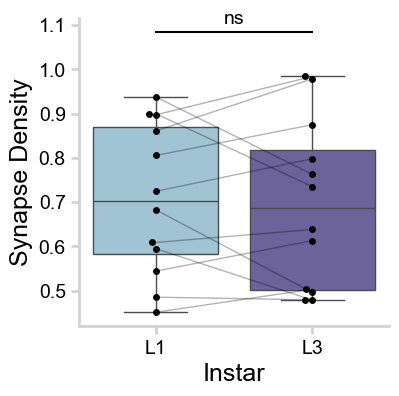

In [ ]:
# # Perform paired t-test
t_stat, p_value = ttest_ind(df_LNs[df_LNs.Instar == 'L1']['synapse density'], df_LNs[df_LNs.Instar == 'L3']['synapse density'])

# Print the results
print("Paired t-test of Overlap ratio vs Input ratio:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Check significance
alpha = 0.05
if p_value < alpha:
    print("Statistically significant.\n")
else:
    print("There is no statistically significant difference.\n")

fig, ax1 = plt.subplots(1, 1, figsize=(4, 4))
sns.boxplot(x='Instar', y='synapse density', data=df_LNs, palette=plot_settings.color_dict)
sns.swarmplot(x='Instar', y='synapse density', data=df_LNs, ax=ax1, color='k')

for i in range(len(df_LNs[df_LNs.Instar == 'L1'])):
    ax1.plot([0, 1], [df_LNs[df_LNs.Instar == 'L1']['synapse density'].iloc[i], df_LNs[df_LNs.Instar == 'L3']['synapse density'].iloc[i]], color='k', linewidth=1, alpha=0.3)
ax1.set_xlabel('Instar')
ax1.set_ylabel('Synapse Density')

# Set the positions for significance stars
x1, x2 = 0, 1   # Positions of the groups (x-axis)
y, h, col = df_LNs['synapse density'].max() + 0.1, 0.01, 'k'  # y position, height, and color
# Add lines and significance stars
ax1.plot([x1, x2], [y, y], lw=1.5, color=col)         # Horizontal line between the groups
ax1.text((x1 + x2) * 0.5, y + h, helper.get_significance_star(p_value), ha='center', va='bottom', color=col, fontsize=14)

# plt.savefig(path_plots+'Fig4/Fig4B.png')
# plt.savefig(path_plots+'Fig4/Fig4B.svg')

np.median(df_LNs[df_LNs.Instar == 'L1']['synapse density'].values), np.median(df_LNs[df_LNs.Instar == 'L3']['synapse density'].values)

### Figure 4 panel C:

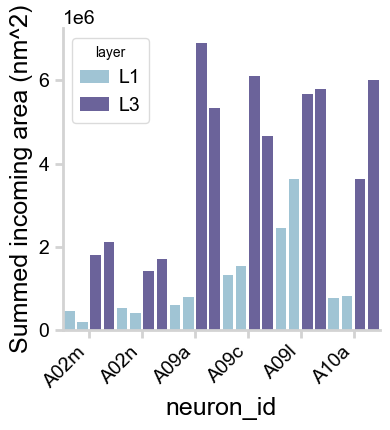

In [12]:
# Add 'layer' column
l1_data = l1_connectors.copy()
l3_data = l3_connectors.copy()
l1_data['layer'] = 'L1'
l3_data['layer'] = 'L3'

combined_data = pd.concat([l1_data, l3_data])
combined_data['cell_type'] = combined_data['target_name'].str.extract(r'(^[^_]+)')
combined_data['neuron_id'] = combined_data['target_name']  # keep full name for bar distinction

grouped = combined_data.groupby(['cell_type', 'neuron_id', 'layer'], as_index=False)['area'].sum()
grouped = grouped.sort_values(by=['cell_type', 'neuron_id'])

plt.figure(figsize=(4, 4.4))
ax = sns.barplot(
    data=grouped,
    x='neuron_id', y='area',
    hue='layer',
    palette=plot_settings.color_dict,
)

cell_types = grouped['cell_type'].unique()
xticks = []
xticklabels = []
group_size = 4  # Assuming 2 neurons per layer (L/R), 2 layers = 4 bars per cell type
for i, ct in enumerate(cell_types):
    center_pos = i * group_size + (group_size - 1) / 2
    xticks.append(center_pos)
    xticklabels.append(ct)

ax.set_xticks([])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45, ha='right')
ax.set_ylabel("Summed incoming area (nm^2)")
plt.tight_layout()

# plt.savefig(path_plots+'Fig4/Fig4C.png')
# plt.savefig(path_plots+'Fig4/Fig4C.svg')

Fold change summed weights:

In [13]:
l1_data_sum = combined_data[combined_data.layer == 'L1'].groupby('target_name').sum('area')
l3_data_sum = combined_data[combined_data.layer == 'L3'].groupby('target_name').sum('area')

(l3_data_sum.area.values / l1_data_sum.area.values).mean()

5.358750555650616

### Figure 4 panel D and E:

In [14]:
l1_data = l1_connectors.copy()
l3_data = l3_connectors.copy()

l1_data_count = l1_data.groupby(['target_name']).size()
l3_data_count = l3_data.groupby(['target_name']).size()

l1_data_sum = l1_data.groupby('target_name').sum('area')
l3_data_sum = l3_data.groupby('target_name').sum('area')
l1_data_sum['layer'] = 'L1'
l3_data_sum['layer'] = 'L3'
l1_data_sum.index = l1_data_sum.index.str[:-4]
l3_data_sum.index = l3_data_sum.index.str[:-4]


LN_sum_ratio_df = pd.DataFrame({
                                  'name': l1_data_sum.index,
                                  'l1 summed weight': l1_data_sum['area'],
                                  'l3 summed weight': l3_data_sum['area'],
                                  'l1 count': l1_data_count.values,
                                  'l3 count': l3_data_count.values,
                                  'abs ratio': l3_data_sum['area'] / l1_data_sum['area'],
                                  'norm ratio': (l3_data_sum['area'] / l3_data_count.values) / (l1_data_sum['area'] / l1_data_count.values),

                                  })
LN_sum_ratio_df

,name,l1 summed weight,l3 summed weight,l1 count,l3 count,abs ratio,norm ratio
target_name,,,,,,,
A02m,A02m,4.492370e+05,1.790274e+06,10,58,3.985144,0.687094
A02m,A02m,1.890159e+05,2.107549e+06,3,69,11.150115,0.484788
A02n,A02n,5.272105e+05,1.406093e+06,19,54,2.667042,0.938404
A02n,A02n,3.935512e+05,1.689948e+06,13,48,4.294099,1.162985
A09a,A09a,5.867033e+05,6.914202e+06,18,187,11.784837,1.134369
A09a,A09a,7.914141e+05,5.328061e+06,20,167,6.732330,0.806267
A09c,A09c,1.327744e+06,6.096207e+06,35,187,4.591403,0.859354
A09c,A09c,1.532485e+06,4.656829e+06,38,152,3.038743,0.759686
A09l,A09l,2.446356e+06,5.665877e+06,47,179,2.316047,0.608124


(0.04589972267874621, 0.034748432906050605)

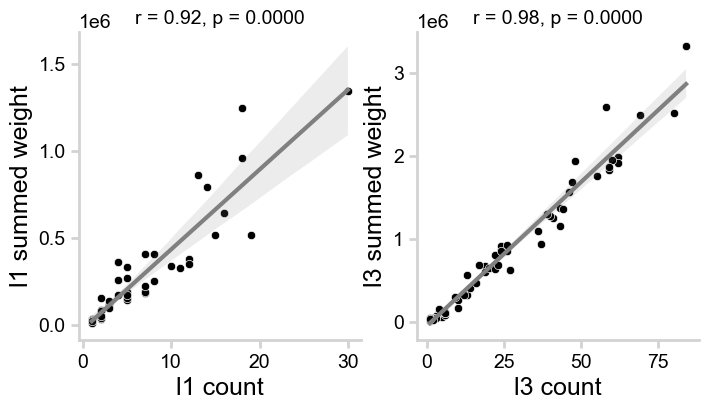

In [15]:
l1_data = l1_connectors.copy()
l3_data = l3_connectors.copy()

l1_data['target_name'] = [c.split('_')[0] + c.split('_')[1][-1] for c in l1_data['target_name']]
l3_data['target_name'] = [c.split('_')[0] + c.split('_')[1][-1] for c in l3_data['target_name']]
l1_data['source_name'] = [c.split('_')[0] + c.split('_')[1][-1] for c in l1_data['source_name']]
l3_data['source_name'] = [c.split('_')[0] + c.split('_')[1][-1] for c in l3_data['source_name']]

l1_data_sum = l1_data.groupby(['target_name','source_name'])['area'].sum()
l3_data_sum = l3_data.groupby(['target_name','source_name'])['area'].sum()

l1_l3_combined_df = pd.DataFrame({
                                  'l1 summed weight': l1_data_sum,
                                  'l3 summed weight': l3_data_sum,
                                  'l1 count': l1_data.groupby(['target_name','source_name'])['area'].count(),
                                  'l3 count': l3_data.groupby(['target_name','source_name'])['area'].count(),
                                  })

# Reset index to make 'target_name' and 'source_name' columns
l1_l3_combined_df = l1_l3_combined_df.reset_index()

# Drop rows with NaN values
l1_l3_combined_df_clean = l1_l3_combined_df.dropna(subset=['l1 count', 'l1 summed weight', 'l3 count', 'l3 summed weight'])
l1_combined_df_cleaned = l1_l3_combined_df.dropna(subset=['l1 count', 'l1 summed weight'])
l3_combined_df_cleaned = l1_l3_combined_df.dropna(subset=['l3 count', 'l3 summed weight'])

# Perform Pearson correlation test
r_l1, p_value_l1 = pearsonr(l1_combined_df_cleaned['l1 count'], l1_combined_df_cleaned['l1 summed weight'])
r_l3, p_value_l3 = pearsonr(l3_combined_df_cleaned['l3 count'], l3_combined_df_cleaned['l3 summed weight'])

# Plot violin plot with hue for target and split by layer
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
# Scatter plot
sns.scatterplot(data=l1_l3_combined_df, x='l1 count', y='l1 summed weight', color='k',
                ax=ax1,
                )
sns.scatterplot(data=l1_l3_combined_df, x='l3 count', y='l3 summed weight', color='k',
                ax=ax2,
                )
sns.regplot(data=l1_l3_combined_df, x='l1 count', y='l1 summed weight', scatter=False, color='grey', ax=ax1)
sns.regplot(data=l1_l3_combined_df, x='l3 count', y='l3 summed weight', scatter=False, color='grey', ax=ax2)
# Calculate correlation coefficient
l1_correlation_coefficient_all = l1_l3_combined_df['l1 count'].corr(l1_l3_combined_df['l1 summed weight'])
l3_correlation_coefficient_all = l1_l3_combined_df['l3 count'].corr(l1_l3_combined_df['l3 summed weight'])
# Add correlation coefficient to plot
ax1.set_title(f'r = {r_l1:.2f}, p = {p_value_l1:.4f}', fontsize=14)
ax2.set_title(f'r = {r_l3:.2f}, p = {p_value_l3:.4f}', fontsize=14)

# Get slopes
slope_l1, intercept_l1, r_value_l1, p_value_l1, std_err_l1 = linregress(l1_combined_df_cleaned['l1 count'], l1_combined_df_cleaned['l1 summed weight'])
slope_l3, intercept_l3, r_value_l3, p_value_l3, std_err_l3 = linregress(l3_combined_df_cleaned['l3 count'], l3_combined_df_cleaned['l3 summed weight'])

# plt.savefig(path_plots+'Fig4/Fig4D_E.png')
# plt.savefig(path_plots+'Fig4/Fig4D_E.svg')

slope_l1 / 1e6, slope_l3 / 1e6

## Supplementary Figure 4 S2

### Supp. Figure 4 S2 panel A:

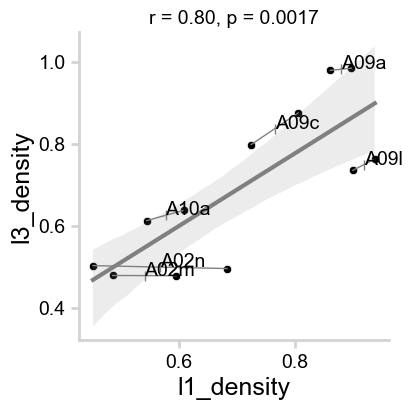

In [16]:
l1_l3_density_df = pd.DataFrame({'Neuron': df_LNs[df_LNs.Instar == 'L1']['Neuron'],
                                 'l1_density': df_LNs[df_LNs.Instar == 'L1']['synapse density'].values,
                                 'l3_density': df_LNs[df_LNs.Instar == 'L3']['synapse density'].values,
                                 })

# Calculate the correlation coefficient and p-value
correlation_c_post_density_dendrite, p_value = pearsonr(l1_l3_density_df['l1_density'], l1_l3_density_df['l3_density'])

fig, ax1 = plt.subplots(1, 1, figsize=(4, 4))
# Plot the cable length and the number of postsynapses
sns.scatterplot(data=l1_l3_density_df, x='l1_density', y='l3_density', ax=ax1, color='k')
# Plot the regression line
sns.regplot(data=l1_l3_density_df, x='l1_density', y='l3_density', ax=ax1, color='grey', scatter=False)
# Set the title with the correlation coefficient and p-value
ax1.set_title(f'r = {correlation_c_post_density_dendrite:.2f}, p = {p_value:.4f}', fontsize=14)
# Connect the same neurons
for i, name in enumerate(l1_l3_density_df.Neuron.unique()):
    neurons = l1_l3_density_df[l1_l3_density_df.Neuron == name]
    ax1.plot(neurons.l1_density, neurons.l3_density, color='grey', linewidth=1)
    # Plot mean dot with a horizontal line
    ax1.scatter(neurons.l1_density.mean(), neurons.l3_density.mean(), color='grey', marker='|', s=50, linewidth=1)
    # Add the name of the neuron
    ax1.text(neurons.l1_density.mean(), neurons.l3_density.mean(), name, fontsize=14)

# plt.savefig(path_plots + 'Fig4/Fig4S2A.png')
# plt.savefig(path_plots + 'Fig4/Fig4S2A.svg')

### Supp. Figure S2 panel B:

(4.945735272902513, 0.8767349816886918)

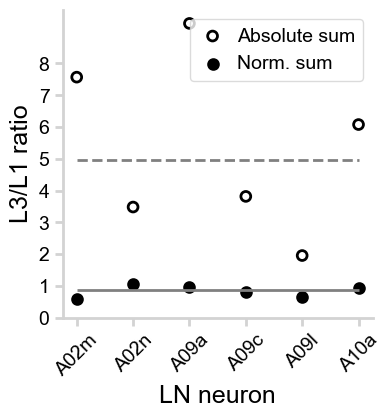

In [17]:
# Plot L3/L1 fraction with diamond markers
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(data=LN_sum_ratio_df.groupby('name').mean(), x='name', y='abs ratio', label='Absolute sum', s=50, fc='none', edgecolor='k', linewidth=2)
sns.scatterplot(data=LN_sum_ratio_df.groupby('name').mean(), x='name', y='norm ratio', label='Norm. sum', s=50, c='k', edgecolor='k', linewidth=2)
ax.hlines([LN_sum_ratio_df.groupby('name').mean()['abs ratio'].median(), LN_sum_ratio_df.groupby('name').mean()['norm ratio'].median()], 0, 5, colors=['grey','grey'], linestyles=['--','-'])

# ax.set_title('Summed weights scaling', fontsize=14)
ax.set_xlabel('LN neuron')
ax.set_ylabel('L3/L1 ratio')
ax.set_yticks(range(0,9,1))
plt.xticks(rotation=45)

# plt.savefig(path_plots+'Fig4/Fig4S2B.png')
# plt.savefig(path_plots+'Fig4/FigS2B.svg')

LN_sum_ratio_df.groupby('name').median()['abs ratio'].median(), LN_sum_ratio_df.groupby('name').median()['norm ratio'].median()